# Example FlowSOM Pipeline

This vignette describes a protocol for analyzing high-dimensional cytometry 
data using FlowSOM, a clustering and visualization algorithm based 
on a self-organizing map (SOM). FlowSOM is used to distinguish cell populations
from cytometry data in an unsupervised way and can help to gain deeper insights
in fields such as immunology and oncology. 

## Loading in the data
FlowSOM handles different inputs, such as an anndata object by pytometry or a filepath. For this purpose we will make use of an anndata object. This allows
easier preprocessing. 

In [2]:
# Import modules
import FlowSOM as fs
import pytometry as pm
import scanpy as sc
import csv
import numpy as np

In [3]:
# Load data
ff = fs.io.read_FCS("../../tests/data/not_preprocessed.fcs")
ff

AnnData object with n_obs × n_vars = 19225 × 18
    var: 'n', 'channel', 'marker', '$PnB', '$PnE', '$PnG', '$PnR', '$PnV'
    uns: 'meta'

We can get an overview of the most important data in our anndata object by using `var`. All the metadata is stored in a dictionary at `ff.uns["meta]`

In [4]:
ff.var

,n,channel,marker,$PnB,$PnE,$PnG,$PnR,$PnV
Time,1,Time,,32,"0,0",0.01,262144,
FSC-A,2,FSC-A,,32,"0,0",1.0,262144,280
FSC-H,3,FSC-H,,32,"0,0",1.0,262144,280
FSC-W,4,FSC-W,,32,"0,0",1.0,262144,280
SSC-A,5,SSC-A,,32,"0,0",1.0,262144,280
SSC-H,6,SSC-H,,32,"0,0",1.0,262144,280
SSC-W,7,SSC-W,,32,"0,0",1.0,262144,280
GFP,8,FITC-A,GFP,32,"0,0",1.0,262144,412
CD8,9,Pacific Blue-A,CD8,32,"0,0",1.0,262144,417
l/d,10,AmCyan-A,l/d,32,"0,0",1.0,262144,496


In [5]:
ff.uns["meta"]

{'__header__': {'FCS format': 'FCS3.0',
  'text start': 58,
  'text end': 5480,
  'data start': 5481,
  'data end': 1389680,
  'analysis start': 0,
  'analysis end': 0},
 '$BEGINANALYSIS': '0',
 '$BEGINDATA': '5481',
 '$BEGINSTEXT': '0',
 '$BTIM': '00:29:01',
 '$BYTEORD': '4,3,2,1',
 '$DATATYPE': 'F',
 '$DATE': '02-JUL-2013',
 '$ENDANALYSIS': '0',
 '$ENDDATA': '1389680',
 '$ENDSTEXT': '0',
 '$ETIM': '00:30:14',
 '$FIL': '68983.fcs',
 '$INST': ' ',
 '$MODE': 'L',
 '$NEXTDATA': 0,
 '$PAR': 18,
 '$SRC': 'T-B-NKT-NK staining BAL',
 '$SYS': 'Windows XP 5.1',
 '$TIMESTEP': '0.01',
 '$TOT': 19225,
 'APPLY COMPENSATION': 'TRUE',
 'AUTOBS': 'TRUE',
 'CREATOR': 'BD FACSDiva Software Version 6.2',
 'EXPERIMENT NAME': '01-07-2013 E20 andere kleuringen',
 'EXPORT TIME': '02-JUL-2013-00:29:00',
 'EXPORT USER NAME': 'Mary',
 'FCSversion': '3',
 'FILENAME': 'Flow Cytometry/data/dataMary/FlowSOM/Uitwerking_27-08-2014/68983.fcs',
 'flowCore_$P10Rmax': '262144',
 'flowCore_$P10Rmin': '-111',
 'flowCore_$

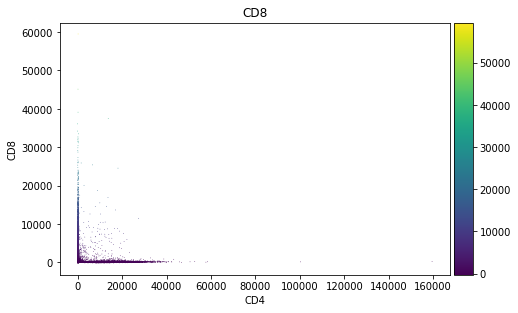

In [6]:
# Visualize data
sc.pl.scatter(ff, x="CD4", y="CD8", color="CD8", size=2)

## Preprocessing
We start with compensating the data and then we transform 
the data with the logicle function. For CyTOF data an arcsinh transformation is 
preferred which is also found in the pytometry package. Besides 
compensation and transformation, we also recommend cleaning the data by removing
margin events and by using cleaning algorithms.

In [7]:
# Compensate
ff_comp = pm.pp.compensate(ff, inplace=False)

# Transform
cols_to_use = [8, 11, 13, 14, 15, 16, 17]
ff_t = fs.pp.normalize_estimate_logicle(ff_comp, cols_to_use)

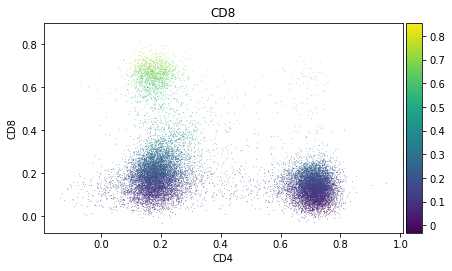

In [8]:
# Visualize data
sc.pl.scatter(ff_t, x="CD4", y="CD8", color="CD8", size=2)

# FlowSOM
The easiest way to use this package is using the wrapper function 
FlowSOM. It has less options than using the separate functions, 
but in general it has enough power. It returns a mudata object, of which the first
modality is the cell data and the second modality is the cluster data. We will
cluster the data with a 10 x 10 SOM grid and 10 metaclusters. Notice that due to the 
just-in-time compilation of numba, the first run of FlowSOM can take a while and 
the subsequent runs will be much faster.

In [9]:
fsom = fs.FlowSOM(ff_t, cols_to_use, xdim = 10, ydim = 10, n_clus = 10)
fsom.mudata

MuData object with n_obs × n_vars = 19225 × 18
  2 modalities
    cell_data:	19225 x 18
      obs:	'clustering', 'distance_to_bmu', 'metaclustering'
      var:	'pretty_colnames', 'markers', 'channels', 'cols_used'
      uns:	'n_nodes', 'n_metaclusters'
    cluster_data:	100 x 18
      obs:	'percentages', 'metaclustering'
      uns:	'xdim', 'ydim', 'outliers', 'graph', 'metacluster_MFIs'
      obsm:	'cv_values', 'sd_values', 'mad_values', 'codes', 'grid', 'layout'

To add the a FlowSOM clustering and metaclustering to an anndata object, we use
flowsom_clustering, similar to other clustering methods in scverse. The FlowSOM
clustering and metaclustering can be found in obs and the parameters used in the
FlowSOM clustering in uns.FlowSOM

In [10]:
ff_clustered = fs.flowsom_clustering(ff_t, cols_to_use, xdim = 10, ydim = 10, n_clus = 10)
ff_clustered

AnnData object with n_obs × n_vars = 19225 × 18
    obs: 'FlowSOM_clusters', 'FlowSOM_metaclusters'
    var: 'n', 'channel', 'marker', '$PnB', '$PnE', '$PnG', '$PnR', '$PnV'
    uns: 'meta', 'FlowSOM'
    layers: 'original'

We can access the cell data and the cluster data with the `get_cell_data()` and 
`get_cluster_data()` functions. 

The *cell data* is an anndata object that contains 
the original cell data. As observations, we find the clustering, metaclustering 
and distance to best matching unit per cell. In var, we find the pretty colnames,
i.e. a combination of markers and channels, the markers, the channels and a 
boolean mask of the columns used for clustering. n_nodes and n_metaclusters in
uns contain the number of clusters and metaclusters respectively.

In [11]:
fsom.get_cell_data()

AnnData object with n_obs × n_vars = 19225 × 18
    obs: 'clustering', 'distance_to_bmu', 'metaclustering'
    var: 'pretty_colnames', 'markers', 'channels', 'cols_used'
    uns: 'n_nodes', 'n_metaclusters'

The *cluster data* contains the original median values per cluster per marker. 
In obsm, we find the cv values, sd values, mad values, coordinates of the nodes, 
coordinates of the the grid and the coordinates of the MST layout. 
The xdim, ydim, outliers, igraph object and metacluster MFIs can be found in uns.

In [12]:
fsom.get_cluster_data()

AnnData object with n_obs × n_vars = 100 × 18
    obs: 'percentages', 'metaclustering'
    uns: 'xdim', 'ydim', 'outliers', 'graph', 'metacluster_MFIs'
    obsm: 'cv_values', 'sd_values', 'mad_values', 'codes', 'grid', 'layout'

## FlowSOM visualizations
A FlowSOM object can be visualized with the `plot_stars()` function

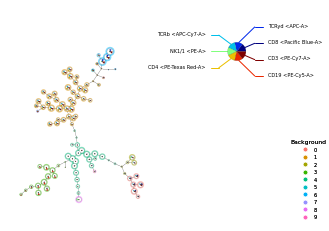

In [13]:
p = fs.pl.plot_stars(fsom, background_values = fsom.get_cluster_data().obs.metaclustering)
p.show()

We can also visualize the grid, to reduce overlap and get a better view of the data. 
The node sizes can be made equal with the equal_node_size argument

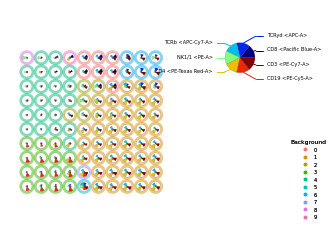

In [14]:
p = fs.pl.plot_stars(fsom, background_values = fsom.get_cluster_data().obs.metaclustering, view = "grid", equal_node_size = True)
p.show()

If you have a label for every cell, we can visualize this with `plot_pies()`. 
Here every node is a piechart with the percentage of cells in each cluster.

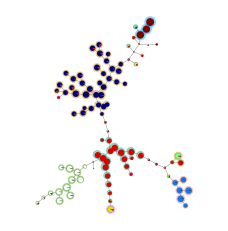

In [15]:
# Read in that data
file = open("../../tests/data/gating_result.csv", "r")
data = csv.reader(file)
data = [i[0] for i in data]

# Plot
p = fs.pl.plot_pies(fsom, data, background_values = fsom.get_cluster_data().obs.metaclustering)

We can also visualize the cluster numbers or metacluster numbers with the help of
`plot_numbers()`, if `level="clusters"` or `level="metaclusters"`, respectively. 
This functions uses `plot_labels()` internally, to which one can pass custom labels,
such as the cell type labels.

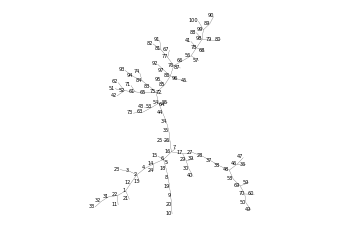

In [16]:
p = fs.pl.plot_numbers(fsom, level = "clusters", text_size = 5)

It is possible to visualize one marker on a FlowSOM tree with the `plot_marker()`
function. This function uses the `plot_variable()` function internally, to which
one can pass custom variables, such as the cell type labels.

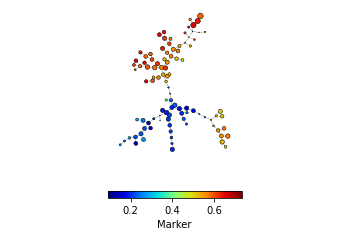

In [17]:
p = fs.pl.plot_marker(fsom, marker = np.array(["CD3"]))